In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import graphviz
from sklearn.metrics import r2_score
import pickle
import json
import scipy.stats as stats

In [17]:
features = ['Rect1Height', 'Rect1Width', 'Rect2Height', 'Rect2Width', 'Rect3Height', 'Rect3Width']
train_data = pd.read_csv('data/E2.csv')
e1a = pd.read_csv('data/E1a.csv')
e1b = pd.read_csv('data/E1b.csv')
e1c = pd.read_csv('data/E1c.csv')
n_quantile = np.arange(0.1, 1., 0.1)

## Train a model

In [18]:
X_train = train_data[features].values
y_train = train_data.response
model = RandomForestRegressor()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.13245376982414192

## Results

In [19]:
def predict(model, data):
    X_test = data[features].values
    y_test = data.RT
    pred = model.predict(X_test)
    return y_test, pred, r2_score(y_test, pred)

In [20]:
def get_predictions(model, data):
    R2 = []
    actual = []
    pred = []
    for d in data:
        a, p, r2 = predict(model, d)
        R2.append(r2)
        actual.append(a)
        pred.append(p)

    actual = np.array(actual)
    pred = np.array(pred)
    return actual, pred, R2

In [21]:
markers = ['o', '^', 'd', 's', '.', '*', 'x', 'p', 'h', 'v']
colors = ['r', 'lime', 'b']
def plot_results(actual, pred):
    plt.figure(figsize=[4.8, 4.8])
    for j in range(len(actual)):
        a = np.sort(actual[j])
        p = np.sort(pred[j])
        a = np.quantile(a, n_quantile)
        p = np.quantile(p, n_quantile)
        plt.scatter(a, p, marker=markers[j], c=colors[1])
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.plot([0, 8], [0, 8])

### Train Results

[-0.17336558099606614,
 -0.20637035560748274,
 -0.986687261981815,
 -0.31381803441879863,
 -0.33803172733174436,
 -0.2238589047447015]

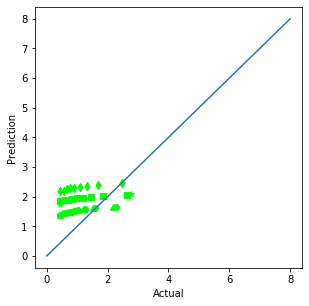

In [22]:
train_effects = [d for _, d in train_data.groupby('Effect')]
actual, pred, r2 = get_predictions(model, train_effects)
plot_results(actual, pred)
r2

### Test results

#### Attraction

-0.07655424200246112

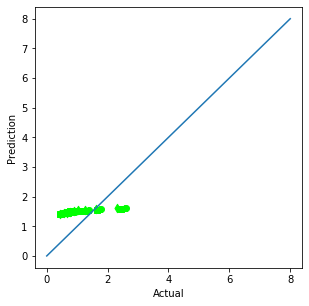

In [23]:
e1a_effects = [d for _, d in e1a.groupby('Effect')]
actual, pred, r2 = get_predictions(model, [*e1a_effects])
plot_results(actual, pred)
np.mean(r2)

#### Compromise

-0.7346045395803045

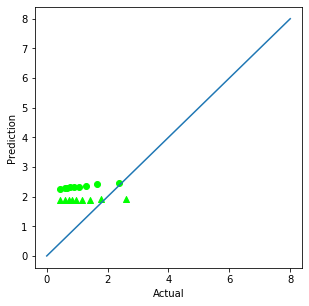

In [24]:
e1b_effects = [d for _, d in e1b.groupby('Effect')]
actual, pred, r2 = get_predictions(model, [*e1b_effects])
plot_results(actual, pred)
np.mean(r2)

#### Similarity

-0.9383306724547277

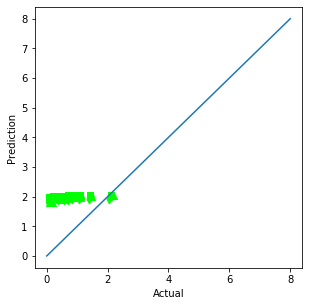

In [25]:
e1c_effects = [d for _, d in e1c.groupby('Effect')]
actual, pred, r2 = get_predictions(model, [*e1c_effects])
plot_results(actual, pred)
np.mean(r2)

# Paper results

In [26]:
cols = ['Cond', 'Time', 'Resp.O1', 'Resp.O2', 'Resp.O3']
def load_paper_data(path):
    with open(path) as f:
        data = json.load(f)
    data = [[s[k] for k in cols] for u in data for s in u]
    data = pd.DataFrame(data=data, columns=cols)
    return data.rename(columns={'Cond': 'Effect'})

experimentData = {
    'e1a': (e1a, load_paper_data('out/e1a.pred.json')),
    'e1b': (e1b, load_paper_data('out/e1b.pred.json')),
    'e1c': (e1c, load_paper_data('out/e1c.pred.json')),
}

In [27]:
def get_paper_predictions(exp):
    actual, pred = experimentData[exp]    
    actual = [[k ,d.RT.values] for k, d in actual.groupby('Effect')]
    pred = [[k, d.Time.values.clip(0, 20)] for k, d in pred.groupby('Effect')]
    actual = np.array([e[1] for e in sorted(actual, key=lambda x: x[0])])
    pred = np.array([e[1] for e in sorted(pred, key=lambda x: x[0])])
    # r2 = [r2_score(a, p) for a, p in zip(actual, pred)]
    return actual, pred, 0

#### Attraction

0.0

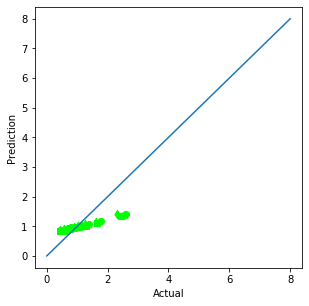

In [28]:
actual, pred, mse = get_paper_predictions('e1a')
plot_results(actual, pred)
np.mean(mse)

#### Compromise

0.0

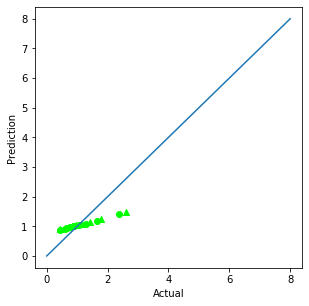

In [29]:
actual, pred, mse = get_paper_predictions('e1b')
plot_results(actual, pred)
np.mean(mse)

#### Similarity

0.0

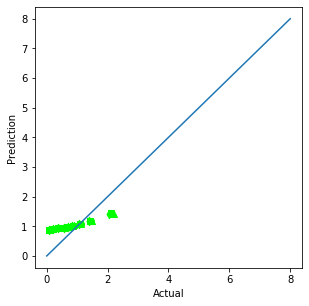

In [30]:
actual, pred, mse = get_paper_predictions('e1c')
plot_results(actual, pred)
np.mean(mse)